In [1]:
from IPython.display import clear_output
from google.colab import files
files.upload()
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d atulanandjha/lfwpeople
!unzip lfwpeople.zip
!tar -xvzf lfw-funneled.tgz
!rm lfw-funneled.tgz lfwpeople.zip
clear_output()

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torchvision import transforms as T
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from glob import glob
from tqdm.notebook import trange, tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report, auc

In [3]:
torch.random.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)

IMAGE_SIZE = 100
BATCH_SIZE = 64
epochs = 200
PATH = r'/content/drive/My Drive/data/face_model_checkpoint.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
img_dir = glob('lfw_funneled/'+'/*/*')
img_dir = [str(x) for x in img_dir]
df = pd.DataFrame(img_dir, columns=['Image_dir'])
df['Name'] = df['Image_dir'].str.split('/', expand=True).loc[:, [1,]]
df.sample(5)

,Image_dir,Name
4430,lfw_funneled/JK_Rowling/JK_Rowling_0004.jpg,JK_Rowling
12342,lfw_funneled/Cristian_Barros/Cristian_Barros_0...,Cristian_Barros
7112,lfw_funneled/Chris_Thomas/Chris_Thomas_0001.jpg,Chris_Thomas
2202,lfw_funneled/Milo_Djukanovic/Milo_Djukanovic_0...,Milo_Djukanovic
4759,lfw_funneled/Pete_Sampras/Pete_Sampras_0009.jpg,Pete_Sampras


In [5]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=123)
train, valid = train_test_split(train, test_size=0.05, shuffle=True, random_state=123)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.shape, valid.shape, test.shape

((11313, 2), (596, 2), (1324, 2))

In [6]:
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.RandomHorizontalFlip(),
                              T.RandomAffine(5, (0.01, 0.2), scale=(0.95, 1.05)),

                              T.ColorJitter(brightness=(0.95, 1.05),
                                            contrast=(0.95, 1.05),
                                            saturation=(0.95, 1.05),
                                            hue=0.05),
                              T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
                              T.RandomRotation(degrees=(-10, 10)),

                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ToTensor(),
                              T.Normalize((0.5), (0.5))
])

valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ToTensor(),
                              T.Normalize((0.5), (0.5))
])

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    if len(faces) > 0:
        for x, y, w, h in faces:
            image2 = image[y: y+h, x: x+w, :]
        image2 = cv2.resize(image2, (IMAGE_SIZE, IMAGE_SIZE))
        return image2, 1
    return image, 0

In [8]:
class FaceDataset(torch.utils.data.Dataset):
      def __init__(self, df, transforms=None, is_cosine=0):
          self.df = df
          self.transforms = transforms
          self.is_cosine = is_cosine

      def __len__(self):
          return len(self.df)

      def __getitem__(self, ix):
          itemA = self.df.loc[ix, 'Image_dir']
          itemA_name = self.df.loc[ix, 'Name']
          same_person = np.random.randint(2)
          if same_person:
              itemB_ser = self.df.loc[self.df.Name == itemA_name, 'Image_dir']
              itemB_idx = itemB_ser.index
              if len(itemB_idx) > 1:
                  itemB = itemB_ser[np.random.choice(itemB_idx)]
                  itemB_name = self.df.loc[self.df['Image_dir'] == itemB, 'Name'].values[0]
              else:
                  same_person = 0
          if not same_person:
              other_persons_idx = self.df.loc[~(self.df.Name == itemA_name), :].index
              itemB_row = self.df.loc[np.random.choice(other_persons_idx)]
              itemB = itemB_row['Image_dir']
              itemB_name = itemB_row['Name']
          imageA = cv2.imread(itemA)
          imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB)
          imageB = cv2.imread(itemB)
          imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB)

          imageA, _ = crop_face(imageA)
          imageB, _ = crop_face(imageB)

          if self.transforms is not None:
              imageA = self.transforms(imageA)
              imageB = self.transforms(imageB)

          label = np.array([1 - (same_person - self.is_cosine)])
          label[label == 2] = -1
                    
          return imageA, imageB, label

      def collate_fn(self, batch):
          imgsA, imgsB, labels = list(zip(*batch))
          imgsA = [img[None] for img in imgsA]
          imgsB = [img[None] for img in imgsB]
          labels = [torch.tensor([label]) for label in labels]
          imgsA, imgsB, labels = [torch.cat(i).to(device) for i in [imgsA, imgsB, labels]]
          return imgsA, imgsB, labels

In [9]:
train_ds = FaceDataset(train, train_transforms, is_cosine=1)
valid_ds = FaceDataset(valid, train_transforms, is_cosine=1)

train_dataloader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, collate_fn=train_ds.collate_fn, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(valid_ds, shuffle=False, batch_size=BATCH_SIZE, collate_fn=valid_ds.collate_fn, drop_last=True)

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=PATH):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss, epoch=None, model=None, optimizer=None, scheduler=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = { 
                          'epoch': epoch,
                          'model': model,
                          'optimizer': optimizer,
                          'scheduler': scheduler,
                          'early': self,
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def load_model(path):
    checkpoint = torch.load(path, map_location=device)
    epoch = checkpoint['epoch']
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    scheduler = checkpoint['scheduler']
    early = checkpoint['early']
    return model, optimizer, epoch, scheduler, early

In [11]:
def convBlock(ni, no):
    return torch.nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, stride=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

class ScratchModel(nn.Module):
    def __init__(self):
        super(ScratchModel, self).__init__()
        self.features = nn.Sequential(
            convBlock(3, 8),
            convBlock(8, 16),
            convBlock(16, 32),
            convBlock(32, 32),
            nn.AdaptiveAvgPool2d((7)),  # 32*7*7
            nn.Flatten(),
            nn.Linear(32*7*7, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )
    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [12]:
model = ScratchModel().to(device)

from torchsummary import summary
summary(model, [(3,IMAGE_SIZE,IMAGE_SIZE), (3,IMAGE_SIZE,IMAGE_SIZE)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1          [-1, 3, 100, 100]               0
            Conv2d-2          [-1, 8, 100, 100]             224
              ReLU-3          [-1, 8, 100, 100]               0
       BatchNorm2d-4          [-1, 8, 100, 100]              16
           Dropout-5          [-1, 8, 100, 100]               0
            Conv2d-6         [-1, 16, 100, 100]           1,168
              ReLU-7         [-1, 16, 100, 100]               0
       BatchNorm2d-8         [-1, 16, 100, 100]              32
           Dropout-9         [-1, 16, 100, 100]               0
           Conv2d-10         [-1, 32, 100, 100]           4,640
             ReLU-11         [-1, 32, 100, 100]               0
      BatchNorm2d-12         [-1, 32, 100, 100]              64
          Dropout-13         [-1, 32, 100, 100]               0
           Conv2d-14         [-1, 32, 1

In [13]:
loss_fn = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
early_stop = EarlyStopping(path=PATH)

In [16]:
def train_one_batch(model, data, optimizer, criterion=loss_fn):
    model.train()
    imgsA, imgsB, labels = data
    labels.squeeze_()
    optimizer.zero_grad()
    featsA, featsB = model(imgsA, imgsB)
    loss = criterion(featsA, featsB, labels)
    loss.backward()
    optimizer.step()

    labels.clamp_(min=0, max=1)
    cosine_sim = F.cosine_similarity(featsA, featsB)  # calculates similarity in range [0,1]. Not distance
    accuracy = ((cosine_sim>0.5) == labels).float().mean()

    return loss.item(), accuracy.item()

@torch.no_grad()
def validate(model, data, criterion=loss_fn):
    model.eval()
    imgsA, imgsB, labels = data
    labels.squeeze_()
    featsA, featsB = model(imgsA, imgsB)
    loss = criterion(featsA, featsB, labels)

    labels.clamp_(min=0, max=1)
    cosine_sim = F.cosine_similarity(featsA, featsB)
    accuracy = ((cosine_sim>0.5) == labels).float().mean()

    return loss.item(), accuracy.item()

def preprocess_input(path):
    input = cv2.imread(path)
    input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
    input, _ = crop_face(input)
    input = valid_transforms(input)[None].to(device)
    return input

In [15]:
train_losses, valid_losses = [], []

for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []
    epoch_train_acc, epoch_valid_acc = [], []

    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss, accuracy = train_one_batch(model, batch, optimizer)
        epoch_train_losses.append(batch_train_loss)
        epoch_train_acc.append(accuracy)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    epoch_train_accuracy = np.array(epoch_train_acc).mean()
    train_losses.append(epoch_train_loss)

    print(f'Train loss: {epoch_train_loss:.4f}, Train accuracy: {epoch_train_accuracy:.4f}')

    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss, accuracy = validate(model, batch)
        epoch_valid_losses.append(batch_valid_loss)
        epoch_valid_acc.append(accuracy)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    epoch_valid_accuracy = np.array(epoch_valid_acc).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}, Valid accuracy: {epoch_valid_accuracy:.4f}')
    print('-'*50)    

    scheduler.step(epoch_valid_loss)
    early_stop(epoch_valid_loss, epoch=epoch, model=model, optimizer=optimizer, scheduler=scheduler)
    if early_stop.early_stop:
        print(f'Validation loss did not improve for {early_stop.patience} epochs. Training stopped.')
        model, optimizer, epoch, scheduler, early = load_model(PATH)
        break

Epoch 1/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.4102, Train accuracy: 0.6202


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.3417, Valid accuracy: 0.6649
--------------------------------------------------
Epoch 2/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3733, Train accuracy: 0.6632


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2917, Valid accuracy: 0.7344
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/face_model_checkpoint.pth
Epoch 3/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3652, Train accuracy: 0.6705


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2876, Valid accuracy: 0.7344
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/face_model_checkpoint.pth
Epoch 4/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3494, Train accuracy: 0.6855


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.3222, Valid accuracy: 0.7014
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 5/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3435, Train accuracy: 0.6911


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2756, Valid accuracy: 0.7361
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/face_model_checkpoint.pth
Epoch 6/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3442, Train accuracy: 0.6903


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2674, Valid accuracy: 0.7396
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/face_model_checkpoint.pth
Epoch 7/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3370, Train accuracy: 0.6937


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2711, Valid accuracy: 0.7500
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 8/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3338, Train accuracy: 0.7002


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2615, Valid accuracy: 0.7535
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/face_model_checkpoint.pth
Epoch 9/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3275, Train accuracy: 0.7023


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2477, Valid accuracy: 0.7726
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/face_model_checkpoint.pth
Epoch 10/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3197, Train accuracy: 0.7077


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2604, Valid accuracy: 0.7569
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 11/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3214, Train accuracy: 0.7092


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2422, Valid accuracy: 0.7760
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/face_model_checkpoint.pth
Epoch 12/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3099, Train accuracy: 0.7200


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2191, Valid accuracy: 0.8160
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/face_model_checkpoint.pth
Epoch 13/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3171, Train accuracy: 0.7097


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2392, Valid accuracy: 0.7743
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 14/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3078, Train accuracy: 0.7169


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2396, Valid accuracy: 0.7865
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 15/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3149, Train accuracy: 0.7164


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2525, Valid accuracy: 0.7483
--------------------------------------------------
INFO: Early stopping counter 3 of 5
Epoch 16/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3057, Train accuracy: 0.7220


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2682, Valid accuracy: 0.7604
--------------------------------------------------
INFO: Early stopping counter 4 of 5
Epoch 17/200


  0%|          | 0/176 [00:00<?, ?it/s]

Train loss: 0.3080, Train accuracy: 0.7170


  0%|          | 0/9 [00:00<?, ?it/s]

Valid loss: 0.2348, Valid accuracy: 0.8021
--------------------------------------------------
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Validation loss did not improve for 5 epochs. Training stopped.


In [17]:
model, optimizer, epoch, scheduler, early = load_model(PATH)

In [20]:
train[train.Name == 'Angelina_Jolie']['Image_dir'].index

Int64Index([  415,   451,   829,  2336,  4012,  5004,  5102,  5516,  5881,
             6268,  7763,  8157, 10833, 10982, 11162],
           dtype='int64')

In [23]:
test[test.Name == 'Jennifer_Pena']['Image_dir'].index

Int64Index([1306], dtype='int64')

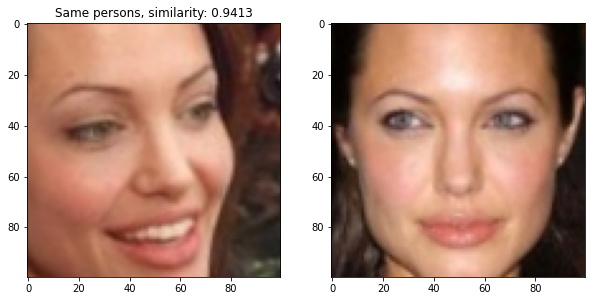

In [21]:
train_im_path = train[train.Name == 'Angelina_Jolie']['Image_dir'].loc[415]
test_im_path = test[test.Name == 'Angelina_Jolie']['Image_dir'].loc[31]
input1 = preprocess_input(train_im_path)
input2 = preprocess_input(test_im_path)
model.eval()
with torch.no_grad():
    out1, out2 = model(input1, input2)
similarity = F.cosine_similarity(out1, out2)
plt.figure(figsize=(10,8))
img1 = cv2.imread(train_im_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.title(f'{"Same" if similarity.item() > 0.5 else "different"} persons, similarity: {similarity.item():.4f}')
plt.imshow(crop_face(img1)[0])
plt.subplot(122)
img2 = cv2.imread(test_im_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(crop_face(img2)[0])
plt.show()

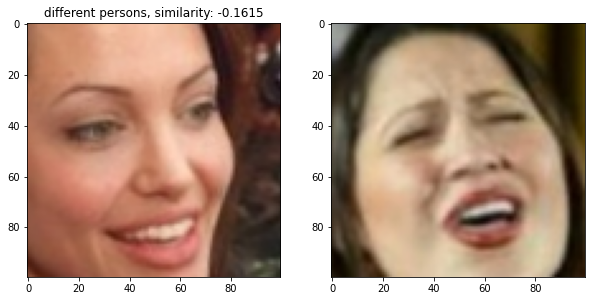

In [24]:
train_im_path = train[train.Name == 'Angelina_Jolie']['Image_dir'].loc[415]
test_im_path = test[test.Name == 'Jennifer_Pena']['Image_dir'].loc[1306]
input1 = preprocess_input(train_im_path)
input2 = preprocess_input(test_im_path)
model.eval()
with torch.no_grad():
    out1, out2 = model(input1, input2)
similarity = F.cosine_similarity(out1, out2)
plt.figure(figsize=(10,8))
img1 = cv2.imread(train_im_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.title(f'{"Same" if similarity.item() > 0.5 else "different"} persons, similarity: {similarity.item():.4f}')
plt.imshow(crop_face(img1)[0])
plt.subplot(122)
img2 = cv2.imread(test_im_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(crop_face(img2)[0])
plt.show()